In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import date
from datetime import timedelta
from fpdf import FPDF
from IPython.display import HTML
import os
import numpy as np
from scipy.signal import savgol_filter

from dateutil import parser
import datetime
import dataframe_image as dfi

os.chdir('../best_deck_yesterday')
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 0 ns (started: 2022-06-12 13:06:51 -04:00)


In [55]:
df = pd.read_csv(r'./../data/raw/lor_ranked_data_all.csv')

time: 1min 44s (started: 2022-06-12 13:06:51 -04:00)


In [56]:
this_day = str(date.today())
yesterday = str(date.today() - timedelta(days = 100))
df_date = df[(df['game_start_time_utc'] < this_day) & (df['game_start_time_utc'] > yesterday)] # keep only the games played yesterday
pdf_n_games_total = df_date.shape[0]

time: 641 ms (started: 2022-06-12 13:08:35 -04:00)


In [57]:
d = datetime.datetime.strptime(yesterday, '%Y-%m-%d')
pdf_yesterday = d.strftime('%b %d, %Y')

time: 0 ns (started: 2022-06-12 13:08:36 -04:00)


In [58]:
n = 3

time: 0 ns (started: 2022-06-12 13:08:36 -04:00)


In [59]:
archetypes = df_date['deck_code'].value_counts()
archetypes = archetypes[archetypes > n]
popular_list = list(archetypes.index)
x = df.loc[df['deck_code'].isin(popular_list)]

time: 1.08 s (started: 2022-06-12 13:08:36 -04:00)


In [60]:
df_champ = x[x['game_outcome'] != "tie"] # get rid of ties
df_champ = df_champ.groupby(['deck_code', 'game_outcome']).size() # group deck codes by outcome
df_champ = df_champ.groupby(level=0).transform(lambda x: (x / x.sum()).round(3)*100) # get winrate
df_champ.drop('loss', level=1, axis=0, inplace=True) # drop losses
df_champ = df_champ.droplevel(level=1) # not sure
df_champ = df_champ.sort_values(ascending=False) # sort so good stuff at top
df_champ = pd.DataFrame({'deck_code':df_champ.index, 'winrate':df_champ.values}) #dataframe w/ column titles

time: 34.4 s (started: 2022-06-12 13:08:37 -04:00)


In [61]:
df_ = df_date[['deck_code', 'archetype']].copy() # make a dataframe with just the stuff you need
_ = pd.merge(df_champ, df_, on=['deck_code'], copy=False).drop_duplicates().reset_index(drop=True)#[:20] # get the archetypes for top decks, drop dupes, reset index, keep top 10

time: 1.3 s (started: 2022-06-12 13:09:11 -04:00)


In [62]:
z = df_date.value_counts('deck_code')
z = pd.DataFrame(z, columns = ['n_games'])
_ = _.merge(z, how='inner', on= 'deck_code')

time: 969 ms (started: 2022-06-12 13:09:12 -04:00)


In [63]:
r = _
r_small = r[['winrate', 'n_games']]
r_small = r_small[r_small['n_games'] < 800]

time: 15 ms (started: 2022-06-12 13:09:13 -04:00)


In [64]:
r_small['n_games'].max()

798

time: 0 ns (started: 2022-06-12 13:09:13 -04:00)


In [65]:
poop = r_small
poop['n_games'].max()

798

time: 15 ms (started: 2022-06-12 13:09:13 -04:00)


In [66]:
s_max = r_small.groupby(['n_games']).max()
s_mean = r_small.groupby(['n_games']).mean()
s_min = r_small.groupby(['n_games']).min()

time: 31 ms (started: 2022-06-12 13:09:14 -04:00)


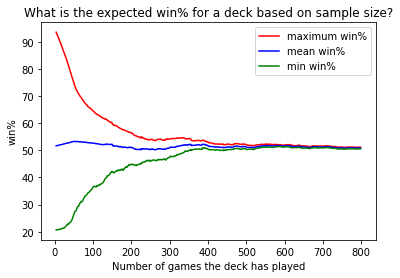

time: 703 ms (started: 2022-06-12 13:10:27 -04:00)


In [73]:
window_len = 75
poly_order = 1

x = s_max.index
yhat = savgol_filter(s_max['winrate'], window_len, poly_order, mode='nearest')

x_mean = s_mean.index
yhat_mean = savgol_filter(s_mean['winrate'], window_len, poly_order, mode='nearest')

x_min = s_min.index
yhat_min = savgol_filter(s_min['winrate'], window_len, poly_order, mode='nearest')

# plt.plot(x, y)
plt.plot(x,yhat, color='red', label="maximum win%")
plt.plot(x_mean, yhat_mean, color='blue', label="mean win%")
plt.plot(x_min, yhat_min, color='green', label="min win%")
plt.title('What is the expected win% for a deck based on sample size?')
plt.xlabel('Number of games the deck has played')
plt.ylabel('win%')
# plt.axhline(y=50, color='y', linestyle='--')
plt.legend()
# plt.show()
plt.savefig('../game_length/winrateByLengthMultiplePatches2.png', dpi=600, facecolor='w')#, transparent=False, bbox_inches='tight')

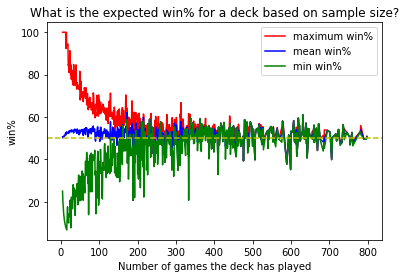

time: 219 ms (started: 2022-06-12 13:09:14 -04:00)


In [68]:
window_len = 75
poly_order = 1

x = s_max.index
# yhat = savgol_filter(s_max['winrate'], window_len, poly_order, mode='nearest')
yhat = s_max['winrate']

x_mean = s_mean.index
# yhat_mean = savgol_filter(s_mean['winrate'], window_len, poly_order, mode='nearest')
yhat_mean = s_mean['winrate']

x_min = s_min.index
# yhat_min = savgol_filter(s_min['winrate'], window_len, poly_order, mode='nearest')
yhat_min = s_min['winrate']

# plt.plot(x, y)
plt.plot(x,yhat, color='red', label="maximum win%")
plt.plot(x_mean, yhat_mean, color='blue', label="mean win%")
plt.plot(x_min, yhat_min, color='green', label="min win%")
plt.title('What is the expected win% for a deck based on sample size?')
plt.xlabel('Number of games the deck has played')
plt.ylabel('win%')
plt.axhline(y=50, color='y', linestyle='--')
plt.legend()
# plt.show()
# plt.savefig('../game_length/winrateByLengthFullPatchUnsmooth.png', dpi=600)

In [69]:
len(yhat)

526

time: 0 ns (started: 2022-06-12 13:09:14 -04:00)


In [70]:
len(y)

NameError: name 'y' is not defined

time: 16 ms (started: 2022-06-12 13:09:14 -04:00)


In [ ]:
sum(_['n_games'])